**Normal and Brownian**

In this notebook, we'll implement MOBOLFI on a toy example with two data sources, one is the normal data, the other is the brownian motion with fixed drifte rate:

 $ \theta \sim \mathbb{N}(\theta|0,I) \\ $
 $ X_n \sim \mathbb{N}(x|\theta,I), n = 1,...,N \\ $
 $ y(t)=\theta dt + \sigma dY(t) \\ $

where $N=20$ are the size of data $X$;  $y(t)$, $t\in \mathbb{R}^+$, is a continuous time process; $\sigma=0.5$ is a fixed variance, $Y(t)$ is a standard Brownian motion and the initial condition $y(0)=0$; we consider the trajectory $y(t)$ on the range $[0,3]$ and $M=50$ (defined as nsteps below) equally spaced observations over this range, i.e.
$Y_m=y((m-1)\delta)$, where $\delta=3/(M-1)$. 

In this toy example, the "real data" is the generated data from simualtor model ($X,Y$ defined above) given a true paramater $\theta_{true}=(-0.7,0.7,...,-0.7,0.7)^T$.
PS: In paper we write W instead of Y as the brownian motion data to avoid conflict of notations. Below, we'll keep using Y as the brownian motion data.

Our first work is to define the simlulator in order to generate the "real data" and define the real theta.

Real theta:[-0.7  0.7 -0.7  0.7 -0.7  0.7 -0.7  0.7 -0.7  0.7]


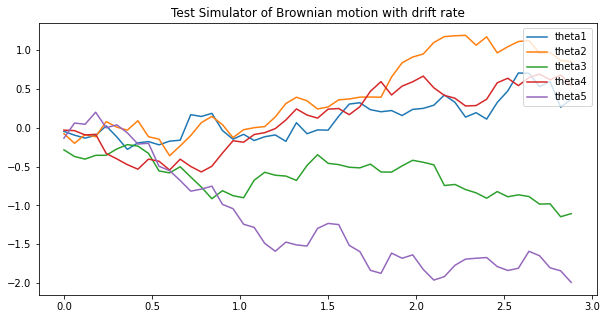

In [42]:
# Build simulator of Brownian Motion with drift rate
import random
import numpy as np
import matplotlib.pyplot as plt

nsteps = 50  # M = 50
interval = 3 # range 0 - 3
def simulate_1d_bm_with_drift(mu, nsteps=nsteps, interval=interval,sigma=0.5): # sigma = 0.5
    """
    mu is a 1 dim 10-elements numpy obj and the drift rate
    nsteps is the size of data source Y
    """
    dt = interval/nsteps
    steps = np.zeros((nsteps,mu.shape[0]))
    for i in range(nsteps):
        steps[i,:] = mu*dt + sigma*np.random.randn(mu.shape[0])*np.sqrt(dt)
    y = np.cumsum(steps,axis=0) # reduce it to be size nsteps-1
    y = y[1:,:]
    t = [ dt*i for i in range(nsteps-1) ]
    return t, steps, y


# Define the real theta
real_theta = np.array([-0.7,0.7,-0.7,0.7,-0.7,0.7,-0.7,0.7,-0.7,0.7])
print("Real theta:{}".format(real_theta))

# Visuals of first 5 traces of Brwonian motion (total 10)
t, steps, y=simulate_1d_bm_with_drift(mu=real_theta)
plt.figure(figsize=(10,5))
plt.plot(t,y[:,0],label="theta1")
plt.plot(t,y[:,1],label="theta2")
plt.plot(t,y[:,2],label="theta3")
plt.plot(t,y[:,3],label="theta4")
plt.plot(t,y[:,4],label="theta5")
plt.legend(loc=1,fontsize=10)
plt.title("Test Simulator of Brownian motion with drift rate")
plt.show()

In [43]:
def simulator(theta):
    '''
    Simulator of joint (X,Y)
    '''
    # Simulate X
    X = np.random.randn(20,theta.shape[0]) # N = 20 obs from N(theta,1)
    for i in range(20):
        X[i,:] = X[i,:] + theta
    
    # Simulate Y
    t, S, Y = simulate_1d_bm_with_drift(mu=theta)

    return X,S,Y
    

In [44]:
# the synthetic "real" data
real_data = simulator(real_theta)
real_data

(array([[ 1.76178198,  2.11397384,  0.00952392,  0.34613901, -0.26834406,
          0.0885288 , -2.60158633,  0.41853585, -2.45709489,  0.74774769],
        [-0.18787633,  0.9095761 ,  0.4051433 ,  1.05474896, -0.86913386,
          2.06154565,  0.76345879,  0.79052255, -0.48680316,  1.00335258],
        [-1.83744186,  0.60412742, -0.03310159,  1.52237057, -0.18937645,
          1.08008172, -1.5517883 ,  1.77065551,  0.58092998,  1.46487008],
        [-1.21132277,  1.17864807,  0.16453164,  1.38894998,  1.26240862,
         -0.20534115, -2.45863749, -0.51733957,  0.51536579,  1.58384928],
        [-1.17772836,  0.96543795, -1.84618654,  1.01459791, -1.25982834,
          1.8880669 , -0.56429994,  2.43224372, -1.07176699,  0.52360526],
        [ 1.00737271,  0.47259475,  1.09498683,  0.50088762, -0.74938901,
          0.69320409, -1.52727653, -0.48943143,  0.28574388,  1.62502483],
        [-0.77963871,  2.00967859, -0.62567941, -0.76618041, -1.0191173 ,
          0.99171645,  0.1505168

Look up mean of X and Y, given drift rate remaining the same across 50 stpes, the incremental change for each step in Y should be similar over all 10 dims (drift rate $\theta$ is fixed once decided during the motion).

In [45]:
np.mean(real_data[0],axis=0) # close to theta_true

array([-0.49131665,  0.7861933 , -0.4223954 ,  0.67186805, -0.39920174,
        0.48108034, -0.61995596,  0.76593748, -0.37158433,  0.6871223 ])

In [46]:
np.mean(real_data[1],axis=0) # the incremental change, should be close to the result in next chunk

array([-4.61574705e-02,  4.17644117e-02, -3.70295347e-02,  2.06125987e-02,
       -4.41202806e-02,  3.40509168e-02,  6.29249792e-06,  7.14956036e-02,
       -4.58185774e-02,  3.79175433e-02])

In [47]:
real_theta*interval/nsteps 

array([-0.042,  0.042, -0.042,  0.042, -0.042,  0.042, -0.042,  0.042,
       -0.042,  0.042])

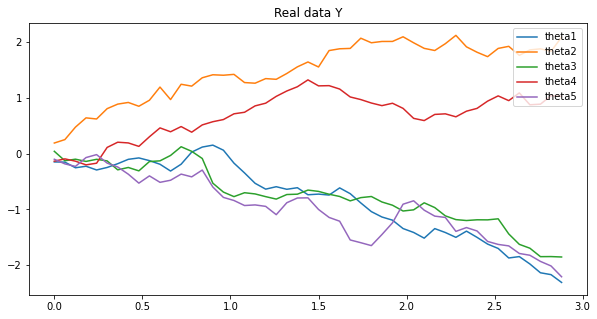

In [48]:
# Visual of Brownian motion traces (part)
plt.figure(figsize=(10,5))
plt.plot(t,real_data[2][:,0],label="theta1")
plt.plot(t,real_data[2][:,1],label="theta2")
plt.plot(t,real_data[2][:,2],label="theta3")
plt.plot(t,real_data[2][:,3],label="theta4")
plt.plot(t,real_data[2][:,4],label="theta5")
plt.legend(loc=1,fontsize=10)
plt.title("Real data Y")
plt.show()

After defining the simulator, the next step is to define the simualtion discrepancy function. This function takes as input a vector of parameters $\theta_i$ (10 dims), outputs the 2-dim vector of simualtion discrepancies $\Delta_1(X^{(i)},X^o),\Delta_2(Y^{(i)},Y^o)$. $i=1,2,...$ denotes the index of observation,

Due to the high dimensionlality of data, the discrepancy function $\Delta$ is in fact applied to the low-dimensional data summary instead of raw data itself. For discrepancy on $X$, Due to the simplicity of this example, we calculating the Euclidean distance between mean of simualtion and mean of real data as the discrepancy. For discrepancy on $Y$, we calculate the Euclidean distance between mean of step changes of simulation and mean of step changes of real data as the discrepancy:

For the dataset $X=\{X_n\}_{n=1}^N$, and corresponding observed data denoted
$\{X_n^o\}_{n=1}^N$, we write $\overline{X}=N^{-1}\sum_n X_n$, $\overline{X}^o=N^{-1}\sum_n X_n$ and the discrepancy for data source $X$ is
$\Delta_1(X,X^o)=\|\overline{X}-\overline{X}^o\|$, where $\|\cdot\|$ denotes the
Euclidean distance.  For data $Y=\{Y_m\}_{m=1}^M$, and observed
data $Y^o=\{Y^o_m\}_{m=1}^M$, we write $\Delta Y_m=Y_{m+1}-Y_m$, $m=1,\dots, M-1$,
$\Delta Y_m^o=Y_{m+1}^o-Y_m^o$, $m=1,\dots, M-1$, $\overline{\Delta Y}=(M-1)^{-1}\sum_{m=1}^{M-1} \Delta Y_m$ and $\overline{\Delta Y^o}=(M-1)^{-1}\sum_{m=1}^{M-1} \Delta Y_m^o$.  Then the discrepancy used for data
source $Y$ is $\Delta_2(Y,Y^o)=\|\overline{\Delta Y}-\overline{\Delta Y^o}\|$.

Easy to see that the data summary chosen here is sufficient.

Given assumption in botorch package we use later, the objectives defined are default to be maximized. Thusly the function below are in fact calculating the negative of discrepnacies.

When optimizing multiple objectives, one important to care is scaling. Depending on data and our needs, we may want to put preference to some data source than the others. Scaling up discrepancy of one data source leads to that EHVI more strongly depends on that discrepancy. There is no easy answer to scaling-the optimal scaling is always depending on cases. In this toy example, we test different scaling and choose the one that results in best approxiamtion to true posterior. In the other works of this paper, the simualtor is expensive and no closed form posterior is offered. We defaultly choose the scaling that put discrepancy of all data sources on a similar scale (rounded to 1 decimal place). However, we admit this may not be the best way to do.

In [49]:
def minus_simluated_discrepancy(theta, real_data=real_data):

    X_obs, Step_obs, _ = real_data[0], real_data[1], real_data[2]
    X_obs_mean = np.mean(X_obs,axis=0)
    Step_obs_mean = np.mean(Step_obs,axis=0)

    X_theta, Step_theta, _ = simulator(theta)
    X_theta_mean = np.mean(X_theta,axis=0)
    discrepancy_X = np.mean(np.abs(X_theta_mean-X_obs_mean))

    Step_theta_mean = np.mean(Step_theta,axis=0)
    discrepancy_Y = np.sum(np.abs(Step_obs_mean-Step_theta_mean),axis=0)
    discrepancy_X *= 0.4 # Scaling
    discrepancies = np.array([discrepancy_X, discrepancy_Y])

    return discrepancies*-1

In [50]:
minus_simluated_discrepancy(real_theta) # Evaluating the discrepancy taking real theeta as input,doens't have to be 0

array([-0.12971865, -0.18215839])

Using function minus_simluated_discrepancy(), we would construct an initial training dataset for training surrogate GP model. It consists of 100 obs $\{\theta_i,\Delta_i\}_{i=1}^{100}$, where $\Delta = (\Delta_1(X^{(i)},X^o),\Delta_2(Y^{(i)},Y^o))$. 

In [51]:
seed = 1248
np.random.seed(seed)

In [52]:
# Firstly, we need to build data for training, i.e. pairs of {theta_i, Delta_i}, i=1,...,N
import pandas as pd

num_init_samples = 100
# Write function that generates training data with larger range
def init_sample_generator(num_init_samples = num_init_samples):
    init_sample_theta = np.zeros((num_init_samples, 10)) # theta dim 10
    init_sample_discrepancy = np.zeros((num_init_samples, 2)) # discrepancy dim 2
    i = 0
    while i < num_init_samples:
        init_theta = np.random.randn(10)
        init_discrepancy = minus_simluated_discrepancy(theta = init_theta)
        if init_discrepancy[0] > -0.7 and init_discrepancy[1] > -1.1: # mild rejection criteria
            init_sample_theta[i,:] = init_theta
            init_sample_discrepancy[i,:] = init_discrepancy
            i += 1
    return init_sample_theta,init_sample_discrepancy
    


In [53]:
init_sample_theta, init_sample_discrepancy = init_sample_generator()
print(pd.DataFrame(init_sample_discrepancy).describe())

                0           1
count  100.000000  100.000000
mean    -0.386564   -0.634700
std      0.080653    0.139777
min     -0.675761   -1.021940
25%     -0.433592   -0.717809
50%     -0.374426   -0.611020
75%     -0.329700   -0.528808
max     -0.234860   -0.360847


In [54]:
# Expect be close to real theta
init_sample_theta[np.argmax(init_sample_discrepancy[:,0]),:] 

array([-1.39464563,  0.31151851, -0.92979921,  1.4433155 , -0.4178393 ,
       -1.00081443,  0.2195467 , -0.17696704,  0.37308063,  0.48637189])

In [55]:
# Expect be close to real theta
init_sample_theta[np.argmax(init_sample_discrepancy[:,1]),:]

array([-0.79167485,  0.52475141, -0.66619091, -0.7090519 , -0.91041601,
        0.02017966,  0.91851584,  1.42145018, -1.85574677,  0.48058084])

We use botorch package in implementing MOBOLFI, the acquisition function is qNEHVI, while the model assumes independence between two objectives. The correlated noise (we assume our observations are noisy) covariacne matrix of the 2 objectives is estimated by sample covariance formula by simulating latest bayesian acquisition, which will be used in constructing the approximate likelihood function.

In [56]:
import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement
from botorch.acquisition.objective import ScalarizedPosteriorTransform
from botorch.optim import optimize_acqf

In [57]:
X = torch.from_numpy(init_sample_theta)
Y = torch.from_numpy(init_sample_discrepancy)

In [58]:
list(init_sample_discrepancy.min(axis=0)-0.1)

[-0.7757606192991264, -1.1219397324168765]

In [59]:
train_X = X.double()
train_Y = Y.double()

# As suggested in https://botorch.org/tutorials/multi_objective_bo, ref point is set ot be the expected lower bound the objectives
# We don't know this bound, but we can set the values to be some value small enough, which is defined here to be min(Delta_1, Delta_2)-0.1
ref_point = list(init_sample_discrepancy.min(axis=0)-0.1)

# Optimization space for theta
bounds = torch.tensor([[-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],[2,2,2,2,2,2,2,2,2,2]],dtype=torch.double)

In [60]:
import time
start_time = time.time()
import warnings
warnings.filterwarnings("ignore")

number_of_iterGPtraining = 200 # change this value to see affect of training iterations on the performance of MOBOLFI

for i in range(number_of_iterGPtraining):
    # For each iteration, train the GP model using current training data
    gp = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    # Define the acuisition function using current training data
    qNEHVI = qNoisyExpectedHypervolumeImprovement(gp, ref_point, train_X)

    candidate, acq_value = optimize_acqf(
      qNEHVI, bounds=bounds, q=1, num_restarts=10, raw_samples=100)


    # Include new acuisition into training data
    train_X = torch.cat((train_X, candidate)).double()
    candidate_X = candidate.flatten().numpy()
    candidate_Y = minus_simluated_discrepancy(theta = candidate_X)
    candidate_Y = torch.from_numpy(candidate_Y)
    train_Y = torch.cat((train_Y, candidate_Y.view(1,-1))).double()

    if i % 5 == 0:
        # Print the newest proposed parameter point and corresponding acuisition function value, real discrepancies and predicted discrepancies (mean)
        print("Iteration: {}\t".format(i+1))
        print("New parameter point: {}\t".format(candidate.tolist()))
        print("Acuisition function value: {}\t".format(acq_value.item()))
        print("Real discrepancy result: {}\t".format(candidate_Y.tolist()))
        print("Predicted discrepancy result: {}\t".format(gp.posterior(candidate).mean.tolist()))




print("Running time for GP training: --- %s seconds ---" % (time.time() - start_time))


Iteration: 1	
New parameter point: [[-1.6017290391027927, -0.026406623423099518, 0.31813969835639, 0.7886568829417229, 0.6255364008247852, -1.1094318106770515, 0.28955764323472977, -0.14263694360852242, -1.0629277750849724, -1.888525914400816]]	
Acuisition function value: 0.0007382679171352678	
Real discrepancy result: [-0.4647588020021578, -0.6568167723091484]	
Predicted discrepancy result: [[-0.38654295283013385, -0.6346985131738118]]	
Iteration: 6	
New parameter point: [[-1.4295525057237934, -1.6322757021419558, 0.04945349291192844, 0.6642328991337212, 0.23457529764392324, -0.7036270201578106, 0.7293926289673731, -0.06926820621928136, -0.6747044248085906, -0.9759247317997182]]	
Acuisition function value: 0.0010843738347143396	
Real discrepancy result: [-0.36574072316291145, -0.7064866853360098]	
Predicted discrepancy result: [[-0.38634154411701627, -0.6315432173092862]]	
Iteration: 11	
New parameter point: [[-1.491159992045909, 0.6038028452209933, 0.006978300361271028, 0.72365658562

In [61]:
# Test gp model prediction, should be close to the minus_simluated_discrepancy(real_theta)
gp.posterior(torch.Tensor(real_theta).view(1,-1)).mean

tensor([[-0.1537, -0.2288]], dtype=torch.float64, grad_fn=<TransposeBackward0>)

In [62]:
# Latest iteration prediction
gp.posterior(train_X[-1,:].view(1,-1)).mean

tensor([[-0.3746, -0.5946]], dtype=torch.float64, grad_fn=<TransposeBackward0>)

In [63]:
# Construct a dataframe that stores all the prediction results
training_results = np.zeros((train_Y.size()[0], 6))

for i in range(train_Y.size()[0]):
    real_obj = train_Y[i,:]
    pred_obj = gp.posterior(train_X[i,:].view(1,-1)).mean
    pred_var = gp.posterior(train_X[i,:].view(1,-1)).variance
    botorchlikelihood1 = torch.distributions.Normal(loc=pred_obj[0][0], scale=pred_var[0][1]).log_prob(real_obj[0])
    botorchlikelihood2 = torch.distributions.Normal(loc=pred_obj[0][0], scale=pred_var[0][1]).log_prob(real_obj[0])
    botorchlikelihood = botorchlikelihood1+botorchlikelihood2
    training_results[i,:] = [i,real_obj[0].item(),real_obj[1].item(),pred_obj[0][0].item(),pred_obj[0][1].item(),botorchlikelihood.item()]

training_results

array([[ 0.00000000e+00, -3.50090766e-01, -5.73261906e-01,
        -3.51203629e-01, -5.81942743e-01,  1.07429591e+01],
       [ 1.00000000e+00, -3.46499950e-01, -7.54283098e-01,
        -3.52730438e-01, -7.36720437e-01, -2.30383669e+01],
       [ 2.00000000e+00, -3.51856316e-01, -5.94211223e-01,
        -3.53251440e-01, -6.02098838e-01,  1.01048375e+01],
       ...,
       [ 2.97000000e+02, -1.14879844e-01, -2.60966799e-01,
        -1.18528289e-01, -2.35203535e-01, -3.27151121e+01],
       [ 2.98000000e+02, -4.71588944e-01, -6.95159198e-01,
        -4.61862477e-01, -6.85549609e-01, -7.04560083e+01],
       [ 2.99000000e+02, -3.46499833e-01, -4.52180712e-01,
        -3.74615862e-01, -5.94582789e-01, -1.66765805e+01]])

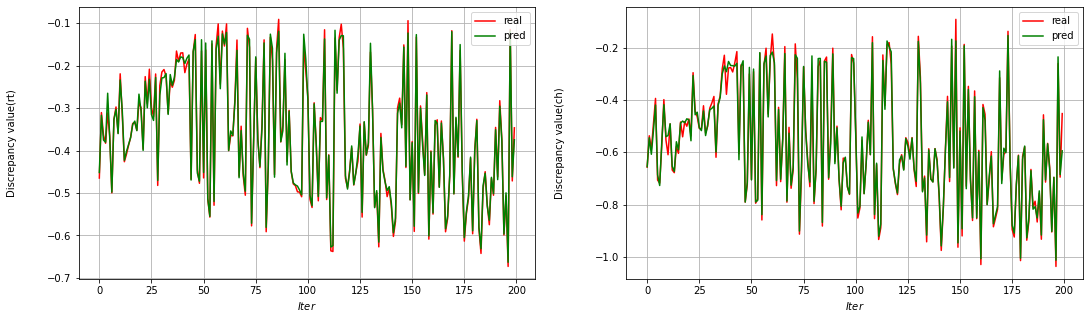

In [64]:
# Draw prediction curves
# Two curves should almost match together, meaning accurate prediction
font_size_text = 10
fs=10


fig, axs = plt.subplots(1, 2, figsize=(18,5))
axs[0].plot(training_results[num_init_samples:,0]-num_init_samples, training_results[num_init_samples:,1], color='red', label='real')
axs[0].plot(training_results[num_init_samples:,0]-num_init_samples, training_results[num_init_samples:,3],'green',label='pred',)
axs[0].legend(loc=1,fontsize=fs)
axs[0].grid()
axs[0].tick_params(axis='both', labelsize=fs)
axs[0].set_xlabel(r'$Iter$',fontsize=font_size_text)
axs[0].set_ylabel(r'Discrepancy value(rt)',fontsize=font_size_text,rotation='vertical',labelpad=30)

axs[1].plot(training_results[num_init_samples:,0]-num_init_samples, training_results[num_init_samples:,2], color='red', label='real')
axs[1].plot(training_results[num_init_samples:,0]-num_init_samples, training_results[num_init_samples:,4],'green',label='pred')
axs[1].legend(loc=1,fontsize=fs)
axs[1].grid()
axs[1].tick_params(axis='both', labelsize=fs)
axs[1].set_xlabel(r'$Iter$',fontsize=font_size_text)
axs[1].set_ylabel(r'Discrepancy value(ch)',fontsize=font_size_text,rotation='vertical',labelpad=30)


plt.show()

In [65]:
# estimate covaraince of noise term using the BO candidate that maximizes the GP likelihood
Y_cov = np.zeros((200,2))
index = np.argmax(training_results[:,-1])
X_cov = train_X[index,:].flatten().numpy()
for i in range(200):
    Y_cov[i,:] = minus_simluated_discrepancy(theta = X_cov)

cov_est_noise = np.cov(Y_cov, rowvar = False)

In [66]:
cov_est_noise

array([[6.68344389e-04, 4.14193299e-05],
       [4.14193299e-05, 2.30180340e-03]])

Now we can build the MOBOLFI approximate likelihood. The function takes as input the parameter $\theta$, trained gp model (and its prediction), choice of tolerance and estimated noise covariance matrix. Tolerance is chosen as the 1% quantile of the total training data by default. But you can change it to see the inference is sensitive to the choice of tolerance.

In [67]:
from scipy.stats import multivariate_normal
tol = torch.quantile(train_Y,q=0.99,dim=0).tolist()# Change q to see the affect of tol level on approxiamte posterior
print(tol)

def approximate_log_likelihood(theta,tol=tol,cov_noise=cov_est_noise,gp=gp,covariance=0):
  theta = theta.view(1,-1)
  preds = gp.posterior(theta)
  means, variances = preds.mean, preds.variance
  means = means.view(-1).detach().numpy() * -1
  Sigma = np.array([[variances[0][0].item(),covariance],
                    [covariance,variances[0][1].item()]])
  cov_matrix = cov_noise + Sigma
  mulnorm = multivariate_normal(mean=means, cov=cov_matrix)
  log_likelihood = torch.Tensor([mulnorm.logcdf([-tol[0],-tol[1]])]).reshape(-1)
  return log_likelihood



[-0.10174210004426179, -0.15647155962014786]


In [68]:
approximate_log_likelihood(theta=train_X[-1,:].view(-1)) #Input is defined to be 1d tensor, which satisfies need of MCMC package

tensor([-30.6164])

In [69]:
approximate_log_likelihood(theta=torch.Tensor(real_theta).view(-1)) # should be a high value

tensor([-4.9104])

In [70]:
def log_prior(theta):# theta is 1d tensor
    '''Define the log prior of theta'''
    lp_log_theta = torch.distributions.Normal(loc=0, scale=1).log_prob(theta)
    # print(lp_log_theta)
    lp = torch.sum(lp_log_theta)

    return lp

In [71]:
log_prior(theta=train_X[-150,:].view(-1))

tensor(-14.8092, dtype=torch.float64)

In [72]:
#Test prior function
priors = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    priors[i] = log_prior(param)

df_describe = pd.DataFrame(priors)
prior_median = df_describe.median()
df_describe.describe()


,0
count,300.000000
mean,-14.404908
std,2.571671
min,-20.586649
25%,-16.475629
50%,-14.396534
75%,-12.127186
max,-9.631719


In [73]:
# Test likelihood function
likelihoods = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    likelihoods[i] = approximate_log_likelihood(param)

df_describe = pd.DataFrame(likelihoods)
df_describe.describe()

,0
count,300.000000
mean,-82.408518
std,55.760371
min,-264.220825
25%,-115.865305
50%,-74.773060
75%,-41.803452
max,-2.490092


In [74]:
# MOBOLFI approximate posterior, from which we apply MCMC to draw saamples of paramters for inference
def approximate_log_posterior(theta):
  ll = approximate_log_likelihood(theta)
  lprior = log_prior(theta)
  lp = lprior + ll - prior_median.item()
  return lp

In [75]:
approximate_log_posterior(theta=candidate.view(-1))

tensor([-30.0478])

For inference methods, we use Hamilton MCMC to draw samples from the approximate posterior, the true posterior would be the sum of log posterior of normal and the log posterior of the Brownian motion (here is a Guassian Process since drift rate is fixed). Compare the samples from MOBOLFI posterior and curves of real posterior.

Note we use HMC just for its fast speed compared to other inference method. In this paper, we do not discuss the pros & cons of various inference methods.

In [76]:
import hamiltorch
%matplotlib inline

In [77]:
hamiltorch.set_random_seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(hamiltorch.__version__)

0.4.1


In [78]:
# Set up the HMC parameters
N = 8000
step_size = .1
L = 1

In [79]:
# HMC
start_time = time.time()
hamiltorch.set_random_seed(123)
params_init = candidate.view(-1)
params_hmc = hamiltorch.sample(log_prob_func=approximate_log_posterior, params_init=params_init, num_samples=N,
                               step_size=step_size, num_steps_per_sample=L)

print("Time for Hamilton MCMC sampling --- %s seconds ---" % (time.time() - start_time))

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:01:07 | 0d:00:00:00 | #################### | 8000/8000 | 118.40       
Acceptance Rate 0.75
Time for Hamilton MCMC sampling --- 67.60757255554199 seconds ---


In [80]:
coords_hmc = torch.cat(params_hmc).reshape(len(params_hmc),-1).numpy()
# burn-in the first 1000 samples
coords_hmc = coords_hmc[1000:,:]

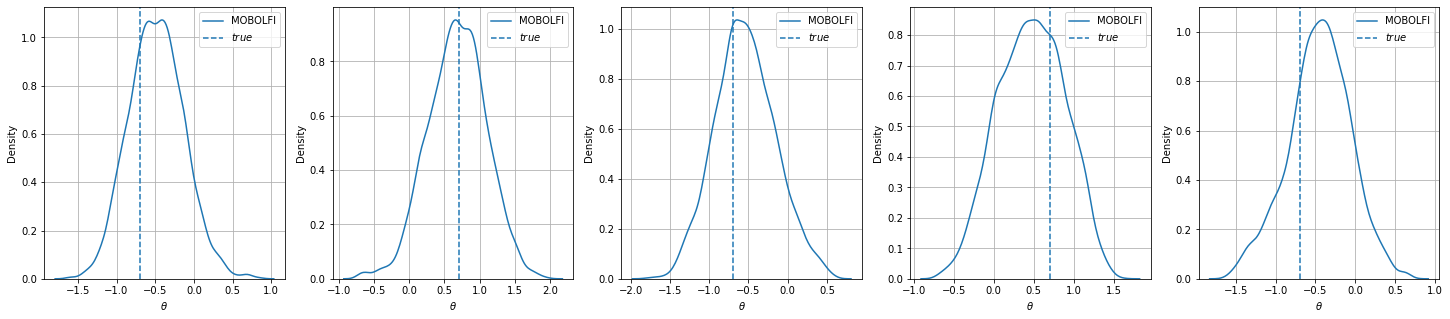

In [81]:
import seaborn as sns
# MOBOLFI vs BOLFI vs real posterior
font_size_text = 10
fs=10

fig, axs = plt.subplots(1, 5, figsize=(25,5))

for i in range(5):
     sns.kdeplot(coords_hmc[:,i], ax=axs[i], label='MOBOLFI')
     axs[i].axvline(real_theta[i],0,1,linestyle="--",label='$true$')
     axs[i].legend(fontsize=fs)
     axs[i].grid()
     axs[i].tick_params(axis='both', labelsize=fs)
     axs[i].set_xlabel(r'$\theta$',fontsize=font_size_text)

To check whether including multiple data sources enahnce the inference, we also draw HMC (Hamilton MCMC) samples from the approxiamte posterior conditional on one data source.

In [82]:
# Approximate likelihood using one data source
tol = torch.quantile(train_Y,q=0.99,dim=0).tolist()
print(tol)

def approximate_log_likelihood_X(theta,tol=tol,cov_noise=cov_est_noise,gp=gp):
  theta = theta.view(1,-1)
  preds = gp.posterior(theta)
  means, variances = preds.mean, preds.variance
  means = means * -1
  item1 = (-tol[0]-means[0][0])/torch.sqrt(variances[0][0]+cov_noise[0][0])
  prob1 = 0.5 * (1 + torch.erf(item1 / torch.sqrt(torch.tensor(2))))
  log_likelihood = torch.log(prob1)
  return log_likelihood

def approximate_log_likelihood_Y(theta,tol=tol,cov_noise=cov_est_noise,gp=gp):
  theta = theta.view(1,-1)
  preds = gp.posterior(theta)
  means, variances = preds.mean, preds.variance
  means = means * -1
  item2 = (-tol[1]-means[0][1])/torch.sqrt(variances[0][1]+cov_noise[1][1])
  prob2 = 0.5 * (1 + torch.erf(item2 / torch.sqrt(torch.tensor(2))))
  log_likelihood = torch.log(prob2)
  return log_likelihood

[-0.10174210004426179, -0.15647155962014786]


In [83]:
print(approximate_log_likelihood_X(theta=train_X[-1,:].view(-1))) #Input is defined to be 1d tensor, which satisfies need of MCMC package
print(approximate_log_likelihood_X(theta=torch.Tensor(real_theta).view(-1))) # should be large

print(approximate_log_likelihood_Y(theta=train_X[-1,:].view(-1))) #Input is defined to be 1d tensor, which satisfies need of MCMC package
print(approximate_log_likelihood_Y(theta=torch.Tensor(real_theta).view(-1))) # should be large


likelihoods_rt = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    likelihoods_rt[i] = approximate_log_likelihood_X(param)

df_describe = pd.DataFrame(likelihoods_rt)
df_describe.describe()

likelihoods_ch = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    likelihoods_ch[i] = approximate_log_likelihood_Y(param)

df_describe = pd.DataFrame(likelihoods_ch)
df_describe.describe()


def approximate_log_posterior_X(theta):
  ll = approximate_log_likelihood_X(theta)
  lprior = log_prior(theta)
  lp = lprior + ll - prior_median.item()
  return lp

def approximate_log_posterior_Y(theta):
  ll = approximate_log_likelihood_Y(theta)
  lprior = log_prior(theta)
  lp = lprior + ll - prior_median.item()
  return lp



hamiltorch.set_random_seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(hamiltorch.__version__)


# Set up the HMC parameters
N = 8000
step_size = .2
L = 1

# HMC for the two likelihood using one data soruce
start_time = time.time()
hamiltorch.set_random_seed(123)
params_init = candidate.view(-1)

params_hmc_X = hamiltorch.sample(log_prob_func=approximate_log_posterior_X, params_init=params_init, num_samples=N,
                               step_size=step_size, num_steps_per_sample=L)

print("Time for Hamilton MCMC sampling --- %s seconds ---" % (time.time() - start_time))


coords_hmc_X = torch.cat(params_hmc_X).reshape(len(params_hmc_X),-1).numpy()
# burn-in the first 1000 samples
coords_hmc_X = coords_hmc_X[1000:,:]


params_hmc_Y = hamiltorch.sample(log_prob_func=approximate_log_posterior_Y, params_init=params_init, num_samples=N,
                               step_size=step_size, num_steps_per_sample=L)

print("Time for Hamilton MCMC sampling --- %s seconds ---" % (time.time() - start_time))


coords_hmc_Y = torch.cat(params_hmc_Y).reshape(len(params_hmc_Y),-1).numpy()
# burn-in the first 1000 samples
coords_hmc_Y = coords_hmc_Y[1000:,:]

tensor(-16.1623, dtype=torch.float64, grad_fn=<LogBackward0>)
tensor(-2.8037, dtype=torch.float64, grad_fn=<LogBackward0>)
tensor(-14.6972, dtype=torch.float64, grad_fn=<LogBackward0>)
tensor(-2.1749, dtype=torch.float64, grad_fn=<LogBackward0>)
0.4.1
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:01:15 | 0d:00:00:00 | #################### | 8000/8000 | 106.59       
Acceptance Rate 0.97
Time for Hamilton MCMC sampling --- 75.12121248245239 seconds ---
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:01:13 | 0d:00:00:00 | #################### | 8000/8000 | 108.77       
Acceptance Rate 0.98
Time for Hamilton MCMC sampling --- 148.80621194839478 seconds ---


As for comparison, the following chunks reproduces BOLFI method using 1-dim training objective. The codes are almost similar to the implementation of MOBOLFI above, except that in BOLFI we define the training objective as the sum of 2 discrepancies (with scaling weight).

In [97]:
def minus_simluated_discrepancy_bolfi(theta, real_data=real_data):

    X_obs, Step_obs, _ = real_data[0], real_data[1], real_data[2]
    X_obs_mean = np.mean(X_obs,axis=0)
    Step_obs_mean = np.mean(Step_obs,axis=0)

    X_theta, Step_theta, _ = simulator(theta)
    X_theta_mean = np.mean(X_theta,axis=0)
    discrepancy_X = np.mean(np.abs(X_theta_mean-X_obs_mean))

    Step_theta_mean = np.mean(Step_theta,axis=0)
    discrepancy_Y = np.sum(np.abs(Step_obs_mean-Step_theta_mean),axis=0)
    discrepancies = np.array([discrepancy_X, discrepancy_Y])
    discrepancy = discrepancies[0]*0.4+discrepancies[1] #scaling weight
    # discrepancy = discrepancies[0] # If you want to use one data source for BOLFI, uncomment this line

    return discrepancy*-1


# Should be small
print(minus_simluated_discrepancy_bolfi(real_theta))


seed = 1248
np.random.seed(seed)


num_init_samples = 100
# Yrite func that generates training data with larger range
def init_sample_generator_bolfi(num_init_samples = num_init_samples):
    init_sample_theta = np.zeros((num_init_samples, 10)) # theta dim 10
    init_sample_discrepancy = np.zeros((num_init_samples, 1)) # discrepancy dim 1
    i = 0
    while i < num_init_samples:
        init_theta = np.random.randn(10)
        init_discrepancy = minus_simluated_discrepancy_bolfi(theta = init_theta)
        if init_discrepancy > -1.5:
            init_sample_theta[i,:] = init_theta
            init_sample_discrepancy[i,:] = init_discrepancy
            i += 1
    return init_sample_theta, init_sample_discrepancy


init_sample_theta, init_sample_discrepancy = init_sample_generator_bolfi()
print(pd.DataFrame(init_sample_discrepancy).describe())



-0.22228369302846965
                0
count  100.000000
mean    -1.012230
std      0.196853
min     -1.452813
25%     -1.138785
50%     -0.980436
75%     -0.881971
max     -0.646348


In [98]:
# Should be close to real theta
init_sample_theta[np.argmax(init_sample_discrepancy[:,]),:] 

array([ 0.29789834, -0.03754759, -0.76468407, -1.23012441,  0.69900879,
       -0.22039664, -0.32370137,  0.20047842, -0.75082117,  1.33816733])

In [99]:
from botorch.acquisition import UpperConfidenceBound

print(init_sample_theta[np.argmax(init_sample_discrepancy),:])
X = torch.from_numpy(init_sample_theta)
Y = torch.from_numpy(init_sample_discrepancy)
train_X = X.double()
train_Y = Y.double()



bounds = torch.tensor([[-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],[2,2,2,2,2,2,2,2,2,2]],dtype=torch.double)

start_time = time.time()
warnings.filterwarnings("ignore")

number_of_iterGPtraining = 200

for i in range(number_of_iterGPtraining):
    # For each iteration, train the GP model using current training data
    gp = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    
    betai = np.sqrt(2*np.log(np.power(i+1,2)*np.power(np.pi,2)/(3*0.1)))
    # Define the acuisition function using current training data
    UCB = UpperConfidenceBound(gp, beta=betai)

    candidate, acq_value = optimize_acqf(
    UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,)


    # Include new acuisition into training data
    train_X = torch.cat((train_X, candidate)).double()
    candidate_X = candidate.flatten().numpy()
    candidate_Y = minus_simluated_discrepancy_bolfi(theta = candidate_X)
    candidate_Y = torch.Tensor([candidate_Y])
    train_Y = torch.cat((train_Y, candidate_Y.view(1,-1))).double()

    if i % 5 == 0:
        # Print the newest proposed parameter point and corresponding acuisition function value, real discrepancies and predicted discrepancies (mean)
        print("Iteration: {}\t".format(i+1))
        print("New parameter point: {}\t".format(candidate.tolist()))
        print("Acuisition function value: {}\t".format(acq_value.item()))
        print("Real discrepancy result: {}\t".format(candidate_Y.tolist()))
        print("Predicted discrepancy result: {}\t".format(gp.posterior(candidate).mean.tolist()))


print("Running time for GP training: --- %s seconds ---" % (time.time() - start_time))

[ 0.29789834 -0.03754759 -0.76468407 -1.23012441  0.69900879 -0.22039664
 -0.32370137  0.20047842 -0.75082117  1.33816733]
Iteration: 1	
New parameter point: [[-1.032563791694072, 1.999977706265844, 0.5278998772236542, 0.125576369035816, -0.9356183125010734, 0.8851267544350887, -1.2795542654262397, 0.274075961980747, 1.390256524102392, 1.1080043458125217]]	
Acuisition function value: -0.6360541014358042	
Real discrepancy result: [-0.7547458410263062]	
Predicted discrepancy result: [[-0.8866488100141219]]	
Iteration: 6	
New parameter point: [[0.2878419300302582, -0.006436145793163711, -0.4671686331360799, 1.3188783832078244, -0.28254729719328897, 1.376259749205222, -0.06655782791752543, 0.12809832801708834, 0.24177911595227178, -0.6365966832678513]]	
Acuisition function value: -0.5641911505190544	
Real discrepancy result: [-0.7266282439231873]	
Predicted discrepancy result: [[-0.9022191169072555]]	
Iteration: 11	
New parameter point: [[-0.0821117671706236, 0.39705510603030564, 0.6917408

tensor([[-0.4416]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)


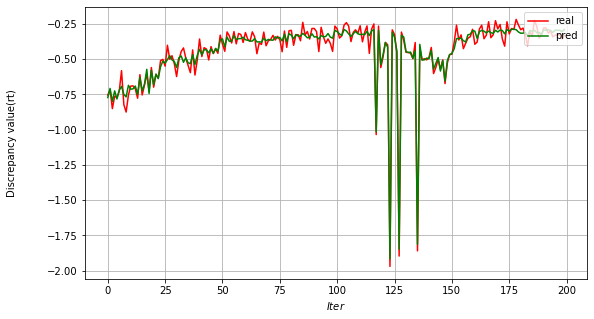

In [100]:
print(gp.posterior(torch.Tensor(real_theta).view(1,-1)).mean)
training_results = np.zeros((train_Y.size()[0], 4))

for i in range(train_Y.size()[0]):
    real_obj = train_Y[i,:]
    pred_obj = gp.posterior(train_X[i,:].view(1,-1)).mean
    pred_var = gp.posterior(train_X[i,:].view(1,-1)).variance
    botorchlikelihood = torch.distributions.Normal(loc=pred_obj, scale=pred_var[0]).log_prob(real_obj)
    training_results[i,:] = [i,real_obj.item(),pred_obj[0].item(),botorchlikelihood.item()]

training_results

# Draw training curves
# Two curves should almost match together, menaing accurate prediction
font_size_text = 10
fs=10


fig, axs = plt.subplots(1, 1, figsize=(9,5))
axs.plot(training_results[num_init_samples:,0]-num_init_samples, training_results[num_init_samples:,1], color='red', label='real')
axs.plot(training_results[num_init_samples:,0]-num_init_samples, training_results[num_init_samples:,2],'green',label='pred',)
axs.legend(loc=1,fontsize=fs)
axs.grid()
axs.tick_params(axis='both', labelsize=fs)
axs.set_xlabel(r'$Iter$',fontsize=font_size_text)
axs.set_ylabel(r'Discrepancy value(rt)',fontsize=font_size_text,rotation='vertical',labelpad=30)



plt.show()

In [101]:
#estimate covaraince using the latest BO acquisition
Y_cov = np.zeros((200,1))
index = np.argmax(training_results[:,-1])
X_cov = train_X[index,:].flatten().numpy()
for i in range(200):
    Y_cov[i,:] = minus_simluated_discrepancy_bolfi(theta = X_cov)

cov_est_noise = np.cov(Y_cov, rowvar = False)



tol = torch.quantile(train_Y,q=0.99).tolist()
print(tol)

def approximate_log_likelihood_bolfi(theta,tol=tol,cov_noise=cov_est_noise,gp=gp,covariance=0):
  theta = theta.view(1,-1)
  preds = gp.posterior(theta)
  means, variances = preds.mean, preds.variance
  means = means.view(-1).detach().numpy() * -1
  Sigma = np.array([variances[0].item()])
  cov_matrix = cov_noise + Sigma
  mulnorm = multivariate_normal(mean=means, cov=cov_matrix)
  log_likelihood = torch.Tensor([mulnorm.logcdf([-tol])]).reshape(-1)
  return log_likelihood



print(approximate_log_likelihood(theta=train_X[-1,:].view(-1))) #Input is defined to be 1d tensor theta, which satisfies need of MCMC package
print(approximate_log_likelihood(theta=torch.Tensor(real_theta).view(-1))) # should be large and larger than value of the chunk above


def log_prior_bolfi(theta):# theta is 1d tensor
    lp_log_theta = torch.distributions.Normal(loc=0, scale=1).log_prob(theta)
    # print(lp_log_theta)
    lp = torch.sum(lp_log_theta)

    return lp

print(log_prior_bolfi(theta=torch.Tensor(real_theta).view(-1))) # should be large and larger than value of the chunk above

#Test prior
priors = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    priors[i] = log_prior_bolfi(param)

df_describe = pd.DataFrame(priors)
prior_median = df_describe.median()
df_describe.describe()

likelihoods = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    likelihoods[i] = approximate_log_likelihood_bolfi(param)

df_describe = pd.DataFrame(likelihoods)
df_describe.describe()



def approximate_log_posterior_bolfi(theta):
  ll = approximate_log_likelihood_bolfi(theta)
  lprior = log_prior_bolfi(theta)
  lp = lprior + ll - prior_median.item()
  return lp

print(approximate_log_posterior_bolfi(theta=torch.Tensor(real_theta).view(-1))) # should be large and larger than value of the chunk above

hamiltorch.set_random_seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(hamiltorch.__version__)


# Set up the HMC parameters
N = 8000
step_size = .2
L = 1

# HMC
start_time = time.time()
hamiltorch.set_random_seed(123)
params_init = candidate.view(-1)
params_hmc_bolfi = hamiltorch.sample(log_prob_func=approximate_log_posterior_bolfi, params_init=params_init, num_samples=N,
                               step_size=step_size, num_steps_per_sample=L)

print("Time for Hamilton MCMC sampling --- %s seconds ---" % (time.time() - start_time))


coords_hmc_bolfi = torch.cat(params_hmc_bolfi).reshape(len(params_hmc_bolfi),-1).numpy()
# burn-in the first 1000 samples
coords_hmc_bolfi = coords_hmc_bolfi[1000:,:]

-0.23461286857724198
tensor([-4.8868])
tensor([-4.9104])
tensor(-11.6394)
tensor([-4.9421])
0.4.1
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:49 | 0d:00:00:00 | #################### | 8000/8000 | 161.03       
Acceptance Rate 0.72
Time for Hamilton MCMC sampling --- 49.716850996017456 seconds ---


Visuals

We firstly calculate the posterior of parameters given real data. Then, compare approximate posterior to the real posterior by visualizing them in one figure via kernel density estimates. Besides comparing the posterior calculated by the joint likelihood, we also compare the posteriors calculated by marginal likelihood of $X$, $Y$.

In [102]:
import math
vxx = torch.linspace(-3,3,200)
p = torch.distributions.Normal(0,1)

# The true posterior function
# Prior is standard normal
# Likelihood consists of two parts: 1. Normal data X follows N(theta,1)  2. Gaussian Process data Y, the step changes of trajectory Y follows N(theta*interval/nsteps,sigma*sqrt(interval/nsteps)) independently


lltheta = torch.linspace(-3,3,200)

true_post = np.zeros((200,10))
true_post_x = np.zeros((200,10))
true_post_y = np.zeros((200,10))

for j in range(10):
    true_post_mar = np.zeros(200)
    true_post_mar_x = np.zeros(200)
    true_post_mar_y = np.zeros(200)
    for i in range(200):
        ltheta = lltheta[i]
        px = torch.distributions.Normal(ltheta,1)
        py = torch.distributions.Normal(ltheta*interval/nsteps,0.5*np.sqrt(interval/nsteps))
        ll_pdfx = torch.sum(px.log_prob(torch.from_numpy(real_data[0][:,j])))
        ll_pdfy = torch.sum(py.log_prob(torch.from_numpy(real_data[1][:,j])))
        true_post_mar_x[i] = np.exp(ll_pdfx + p.log_prob(ltheta))
        true_post_mar_y[i] = np.exp(ll_pdfy + p.log_prob(ltheta))
        true_post_mar[i] = np.exp(ll_pdfx + ll_pdfy + p.log_prob(ltheta))
    

    true_post_mar = (true_post_mar - np.min(true_post_mar))/(np.max(true_post_mar)-np.min(true_post_mar))
    true_post_mar_x = (true_post_mar_x - np.min(true_post_mar_x))/(np.max(true_post_mar_x)-np.min(true_post_mar_x))
    true_post_mar_y = (true_post_mar_y - np.min(true_post_mar_y))/(np.max(true_post_mar_y)-np.min(true_post_mar_y))
    true_post[:,j] = true_post_mar
    true_post_x[:,j] = true_post_mar_x
    true_post_y[:,j] = true_post_mar_y


true_post


array([[8.87633854e-043, 0.00000000e+000, 3.23796369e-046, ...,
        0.00000000e+000, 2.07544257e-045, 0.00000000e+000],
       [9.73878120e-042, 8.28600286e-099, 3.91288411e-045, ...,
        6.53482769e-108, 2.45259089e-044, 1.93461269e-094],
       [1.03693727e-040, 3.31935723e-097, 4.58880141e-044, ...,
        3.08234170e-106, 2.81265765e-043, 7.14809722e-093],
       ...,
       [2.25589670e-089, 9.96898584e-036, 1.51452993e-084, ...,
        1.30329934e-030, 1.18618967e-085, 2.03230723e-038],
       [6.52555416e-091, 1.08923789e-036, 4.81169488e-086, ...,
        1.68295724e-031, 3.68773261e-087, 2.04381354e-039],
       [0.00000000e+000, 1.15497083e-037, 0.00000000e+000, ...,
        2.10900954e-032, 0.00000000e+000, 1.99466469e-040]])

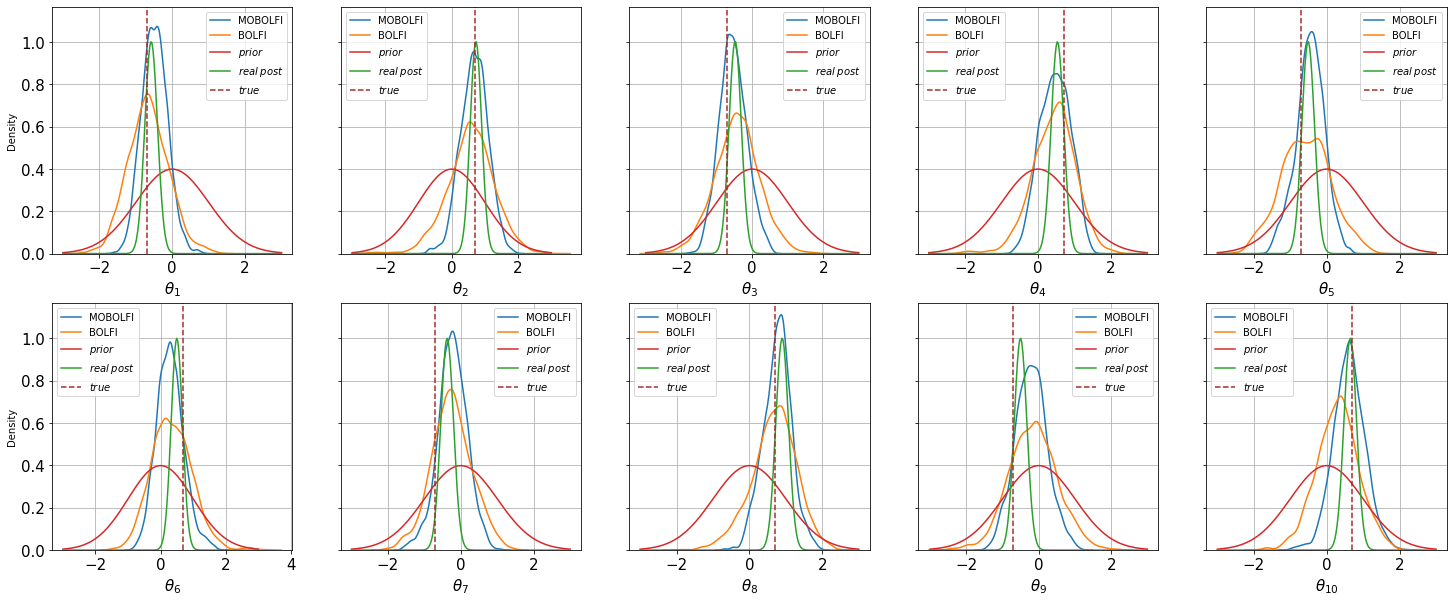

In [103]:
import seaborn as sns
# MOBOLFI vs BOLFI vs real posterior
font_size_text = 15
fs=15

vxx = torch.linspace(-3,3,200)
p = torch.distributions.Normal(0,1)
prior_pdf = torch.exp(p.log_prob(vxx))



fig, axs = plt.subplots(2, 5, figsize=(25,10),sharey=True)

sns.kdeplot(coords_hmc[:,0], ax=axs[0][0], label='MOBOLFI')
sns.kdeplot(coords_hmc_bolfi[:,0], ax=axs[0][0], label='BOLFI')
axs[0][0].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[0][0].plot(lltheta.numpy(), true_post[:,0],label='$real\;post$')
axs[0][0].axvline(real_theta[0],0,1,linestyle="--",c='brown',label='$true$')
axs[0][0].legend(loc=1,fontsize=fs-5)
axs[0][0].grid()
axs[0][0].tick_params(axis='both', labelsize=fs)
axs[0][0].set_xlabel(r'$\theta_1$',fontsize=font_size_text)


sns.kdeplot(coords_hmc[:,1], ax=axs[0][1], label='MOBOLFI')
sns.kdeplot(coords_hmc_bolfi[:,1], ax=axs[0][1], label='BOLFI')
axs[0][1].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[0][1].plot(lltheta.numpy(), true_post[:,1],label='$real\;post$')
axs[0][1].axvline(real_theta[1],0,1,linestyle="--",c='brown',label='$true$')
axs[0][1].legend(loc=2,fontsize=fs-5)
axs[0][1].grid()
axs[0][1].tick_params(axis='both', labelsize=fs)
axs[0][1].set_xlabel(r'$\theta_2$',fontsize=font_size_text)


sns.kdeplot(coords_hmc[:,2], ax=axs[0][2], label='MOBOLFI')
sns.kdeplot(coords_hmc_bolfi[:,2], ax=axs[0][2], label='BOLFI')
axs[0][2].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[0][2].plot(lltheta.numpy(), true_post[:,2],label='$real\;post$')
axs[0][2].axvline(real_theta[2],0,1,linestyle="--",c='brown',label='$true$')
axs[0][2].legend(loc=1,fontsize=fs-5)
axs[0][2].grid()
axs[0][2].tick_params(axis='both', labelsize=fs)
axs[0][2].set_xlabel(r'$\theta_3$',fontsize=font_size_text)


sns.kdeplot(coords_hmc[:,3], ax=axs[0][3], label='MOBOLFI')
sns.kdeplot(coords_hmc_bolfi[:,3], ax=axs[0][3], label='BOLFI')
axs[0][3].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[0][3].plot(lltheta.numpy(), true_post[:,3],label='$real\;post$')
axs[0][3].axvline(real_theta[3],0,1,linestyle="--",c='brown',label='$true$')
axs[0][3].legend(loc=2,fontsize=fs-5)
axs[0][3].grid()
axs[0][3].tick_params(axis='both', labelsize=fs)
axs[0][3].set_xlabel(r'$\theta_4$',fontsize=font_size_text)


sns.kdeplot(coords_hmc[:,4], ax=axs[0][4], label='MOBOLFI')
sns.kdeplot(coords_hmc_bolfi[:,4], ax=axs[0][4], label='BOLFI')
axs[0][4].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[0][4].plot(lltheta.numpy(), true_post[:,4],label='$real\;post$')
axs[0][4].axvline(real_theta[4],0,1,linestyle="--",c='brown',label='$true$')
axs[0][4].legend(loc=1,fontsize=fs-5)
axs[0][4].grid()
axs[0][4].tick_params(axis='both', labelsize=fs)
axs[0][4].set_xlabel(r'$\theta_5$',fontsize=font_size_text)


sns.kdeplot(coords_hmc[:,5], ax=axs[1][0], label='MOBOLFI')
sns.kdeplot(coords_hmc_bolfi[:,5], ax=axs[1][0], label='BOLFI')
axs[1][0].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[1][0].plot(lltheta.numpy(), true_post[:,5],label='$real\;post$')
axs[1][0].axvline(real_theta[5],0,1,linestyle="--",c='brown',label='$true$')
axs[1][0].legend(loc=2,fontsize=fs-5)
axs[1][0].grid()
axs[1][0].tick_params(axis='both', labelsize=fs)
axs[1][0].set_xlabel(r'$\theta_6$',fontsize=font_size_text)


sns.kdeplot(coords_hmc[:,6], ax=axs[1][1], label='MOBOLFI')
sns.kdeplot(coords_hmc_bolfi[:,6], ax=axs[1][1], label='BOLFI')
axs[1][1].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[1][1].plot(lltheta.numpy(), true_post[:,6],label='$real\;post$')
axs[1][1].axvline(real_theta[6],0,1,linestyle="--",c='brown',label='$true$')
axs[1][1].legend(loc=1,fontsize=fs-5)
axs[1][1].grid()
axs[1][1].tick_params(axis='both', labelsize=fs)
axs[1][1].set_xlabel(r'$\theta_7$',fontsize=font_size_text)


sns.kdeplot(coords_hmc[:,7], ax=axs[1][2], label='MOBOLFI')
sns.kdeplot(coords_hmc_bolfi[:,7], ax=axs[1][2], label='BOLFI')
axs[1][2].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[1][2].plot(lltheta.numpy(), true_post[:,7],label='$real\;post$')
axs[1][2].axvline(real_theta[7],0,1,linestyle="--",c='brown',label='$true$')
axs[1][2].legend(loc=2,fontsize=fs-5)
axs[1][2].grid()
axs[1][2].tick_params(axis='both', labelsize=fs)
axs[1][2].set_xlabel(r'$\theta_8$',fontsize=font_size_text)


sns.kdeplot(coords_hmc[:,8], ax=axs[1][3], label='MOBOLFI')
sns.kdeplot(coords_hmc_bolfi[:,8], ax=axs[1][3], label='BOLFI')
axs[1][3].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[1][3].plot(lltheta.numpy(), true_post[:,8],label='$real\;post$')
axs[1][3].axvline(real_theta[8],0,1,linestyle="--",c='brown',label='$true$')
axs[1][3].legend(loc=1,fontsize=fs-5)
axs[1][3].grid()
axs[1][3].tick_params(axis='both', labelsize=fs)
axs[1][3].set_xlabel(r'$\theta_9$',fontsize=font_size_text)


sns.kdeplot(coords_hmc[:,9], ax=axs[1][4], label='MOBOLFI')
sns.kdeplot(coords_hmc_bolfi[:,9], ax=axs[1][4], label='BOLFI')
axs[1][4].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[1][4].plot(lltheta.numpy(), true_post[:,9],label='$real\;post$')
axs[1][4].axvline(real_theta[9],0,1,linestyle="--",c='brown',label='$true$')
axs[1][4].legend(loc=2,fontsize=fs-5)
axs[1][4].grid()
axs[1][4].tick_params(axis='both', labelsize=fs)
axs[1][4].set_xlabel(r'$\theta_{10}$',fontsize=font_size_text)






plt.show()

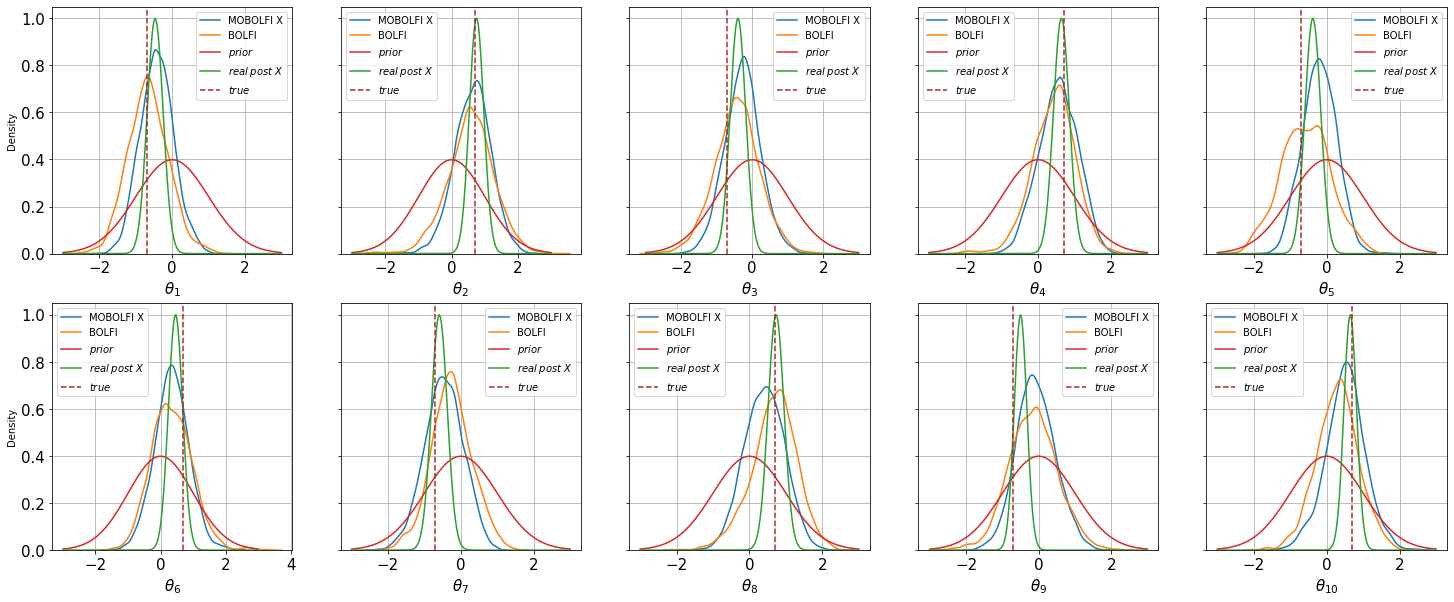

In [104]:
fig, axs = plt.subplots(2, 5, figsize=(25,10),sharey=True)

# MOBOLFI using X data only vs BOLFI vs real post of X 

sns.kdeplot(coords_hmc_X[:,0], ax=axs[0][0], label='MOBOLFI X')
sns.kdeplot(coords_hmc_bolfi[:,0], ax=axs[0][0], label='BOLFI')
axs[0][0].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[0][0].plot(lltheta.numpy(), true_post_x[:,0],label='$real\;post\;X$')
axs[0][0].axvline(real_theta[0],0,1,linestyle="--",c='brown',label='$true$')
axs[0][0].legend(loc=1,fontsize=fs-5)
axs[0][0].grid()
axs[0][0].tick_params(axis='both', labelsize=fs)
axs[0][0].set_xlabel(r'$\theta_{1}$',fontsize=font_size_text)


sns.kdeplot(coords_hmc_X[:,1], ax=axs[0][1], label='MOBOLFI X')
sns.kdeplot(coords_hmc_bolfi[:,1], ax=axs[0][1], label='BOLFI')
axs[0][1].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[0][1].plot(lltheta.numpy(), true_post_x[:,1],label='$real\;post\;X$')
axs[0][1].axvline(real_theta[1],0,1,linestyle="--",c='brown',label='$true$')
axs[0][1].legend(loc=2,fontsize=fs-5)
axs[0][1].grid()
axs[0][1].tick_params(axis='both', labelsize=fs)
axs[0][1].set_xlabel(r'$\theta_{2}$',fontsize=font_size_text)


sns.kdeplot(coords_hmc_X[:,2], ax=axs[0][2], label='MOBOLFI X')
sns.kdeplot(coords_hmc_bolfi[:,2], ax=axs[0][2], label='BOLFI')
axs[0][2].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[0][2].plot(lltheta.numpy(), true_post_x[:,2],label='$real\;post\;X$')
axs[0][2].axvline(real_theta[2],0,1,linestyle="--",c='brown',label='$true$')
axs[0][2].legend(loc=1,fontsize=fs-5)
axs[0][2].grid()
axs[0][2].tick_params(axis='both', labelsize=fs)
axs[0][2].set_xlabel(r'$\theta_{3}$',fontsize=font_size_text)

sns.kdeplot(coords_hmc_X[:,3], ax=axs[0][3], label='MOBOLFI X')
sns.kdeplot(coords_hmc_bolfi[:,3], ax=axs[0][3], label='BOLFI')
axs[0][3].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[0][3].plot(lltheta.numpy(), true_post_x[:,3],label='$real\;post\;X$')
axs[0][3].axvline(real_theta[3],0,1,linestyle="--",c='brown',label='$true$')
axs[0][3].legend(loc=2,fontsize=fs-5)
axs[0][3].grid()
axs[0][3].tick_params(axis='both', labelsize=fs)
axs[0][3].set_xlabel(r'$\theta_{4}$',fontsize=font_size_text)

sns.kdeplot(coords_hmc_X[:,4], ax=axs[0][4], label='MOBOLFI X')
sns.kdeplot(coords_hmc_bolfi[:,4], ax=axs[0][4], label='BOLFI')
axs[0][4].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[0][4].plot(lltheta.numpy(), true_post_x[:,4],label='$real\;post\;X$')
axs[0][4].axvline(real_theta[4],0,1,linestyle="--",c='brown',label='$true$')
axs[0][4].legend(loc=1,fontsize=fs-5)
axs[0][4].grid()
axs[0][4].tick_params(axis='both', labelsize=fs)
axs[0][4].set_xlabel(r'$\theta_{5}$',fontsize=font_size_text)

sns.kdeplot(coords_hmc_X[:,5], ax=axs[1][0], label='MOBOLFI X')
sns.kdeplot(coords_hmc_bolfi[:,5], ax=axs[1][0], label='BOLFI')
axs[1][0].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[1][0].plot(lltheta.numpy(), true_post_x[:,5],label='$real\;post\;X$')
axs[1][0].axvline(real_theta[5],0,1,linestyle="--",c='brown',label='$true$')
axs[1][0].legend(loc=2,fontsize=fs-5)
axs[1][0].grid()
axs[1][0].tick_params(axis='both', labelsize=fs)
axs[1][0].set_xlabel(r'$\theta_{6}$',fontsize=font_size_text)

sns.kdeplot(coords_hmc_X[:,6], ax=axs[1][1], label='MOBOLFI X')
sns.kdeplot(coords_hmc_bolfi[:,6], ax=axs[1][1], label='BOLFI')
axs[1][1].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[1][1].plot(lltheta.numpy(), true_post_x[:,6],label='$real\;post\;X$')
axs[1][1].axvline(real_theta[6],0,1,linestyle="--",c='brown',label='$true$')
axs[1][1].legend(loc=1,fontsize=fs-5)
axs[1][1].grid()
axs[1][1].tick_params(axis='both', labelsize=fs)
axs[1][1].set_xlabel(r'$\theta_{7}$',fontsize=font_size_text)

sns.kdeplot(coords_hmc_X[:,7], ax=axs[1][2], label='MOBOLFI X')
sns.kdeplot(coords_hmc_bolfi[:,7], ax=axs[1][2], label='BOLFI')
axs[1][2].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[1][2].plot(lltheta.numpy(), true_post_x[:,7],label='$real\;post\;X$')
axs[1][2].axvline(real_theta[7],0,1,linestyle="--",c='brown',label='$true$')
axs[1][2].legend(loc=2,fontsize=fs-5)
axs[1][2].grid()
axs[1][2].tick_params(axis='both', labelsize=fs)
axs[1][2].set_xlabel(r'$\theta_{8}$',fontsize=font_size_text)

sns.kdeplot(coords_hmc_X[:,8], ax=axs[1][3], label='MOBOLFI X')
sns.kdeplot(coords_hmc_bolfi[:,8], ax=axs[1][3], label='BOLFI')
axs[1][3].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[1][3].plot(lltheta.numpy(), true_post[:,8],label='$real\;post\;X$')
axs[1][3].axvline(real_theta[8],0,1,linestyle="--",c='brown',label='$true$')
axs[1][3].legend(loc=1,fontsize=fs-5)
axs[1][3].grid()
axs[1][3].tick_params(axis='both', labelsize=fs)
axs[1][3].set_xlabel(r'$\theta_{9}$',fontsize=font_size_text)

sns.kdeplot(coords_hmc_X[:,9], ax=axs[1][4], label='MOBOLFI X')
sns.kdeplot(coords_hmc_bolfi[:,9], ax=axs[1][4], label='BOLFI')
axs[1][4].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[1][4].plot(lltheta.numpy(), true_post[:,9],label='$real\;post\;X$')
axs[1][4].axvline(real_theta[9],0,1,linestyle="--",c='brown',label='$true$')
axs[1][4].legend(loc=2,fontsize=fs-5)
axs[1][4].grid()
axs[1][4].tick_params(axis='both', labelsize=fs)
axs[1][4].set_xlabel(r'$\theta_{10}$',fontsize=font_size_text)

plt.show()


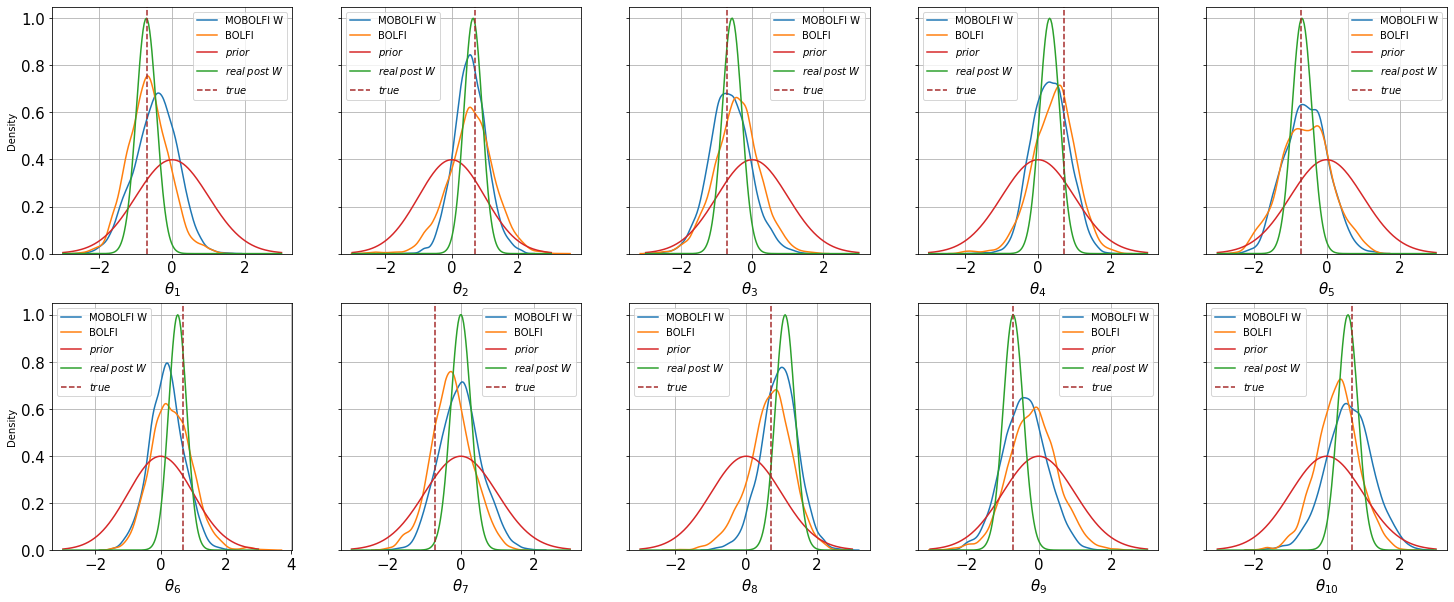

In [105]:
fig, axs = plt.subplots(2, 5, figsize=(25,10),sharey=True)

# MOBOLFI using Y data only vs BOLFI vs real post of Y

sns.kdeplot(coords_hmc_Y[:,0], ax=axs[0][0], label='MOBOLFI W')
sns.kdeplot(coords_hmc_bolfi[:,0], ax=axs[0][0], label='BOLFI')
axs[0][0].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[0][0].plot(lltheta.numpy(), true_post_y[:,0],label='$real\;post\;W$')
axs[0][0].axvline(real_theta[0],0,1,linestyle="--",c='brown',label='$true$')
axs[0][0].legend(loc=1,fontsize=fs-5)
axs[0][0].grid()
axs[0][0].tick_params(axis='both', labelsize=fs)
axs[0][0].set_xlabel(r'$\theta_{1}$',fontsize=font_size_text)


sns.kdeplot(coords_hmc_Y[:,1], ax=axs[0][1], label='MOBOLFI W')
sns.kdeplot(coords_hmc_bolfi[:,1], ax=axs[0][1], label='BOLFI')
axs[0][1].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[0][1].plot(lltheta.numpy(), true_post_y[:,1],label='$real\;post\;W$')
axs[0][1].axvline(real_theta[1],0,1,linestyle="--",c='brown',label='$true$')
axs[0][1].legend(loc=2,fontsize=fs-5)
axs[0][1].grid()
axs[0][1].tick_params(axis='both', labelsize=fs)
axs[0][1].set_xlabel(r'$\theta_{2}$',fontsize=font_size_text)


sns.kdeplot(coords_hmc_Y[:,2], ax=axs[0][2], label='MOBOLFI W')
sns.kdeplot(coords_hmc_bolfi[:,2], ax=axs[0][2], label='BOLFI')
axs[0][2].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[0][2].plot(lltheta.numpy(), true_post_y[:,2],label='$real\;post\;W$')
axs[0][2].axvline(real_theta[2],0,1,linestyle="--",c='brown',label='$true$')
axs[0][2].legend(loc=1,fontsize=fs-5)
axs[0][2].grid()
axs[0][2].tick_params(axis='both', labelsize=fs)
axs[0][2].set_xlabel(r'$\theta_{3}$',fontsize=font_size_text)


sns.kdeplot(coords_hmc_Y[:,3], ax=axs[0][3], label='MOBOLFI W')
sns.kdeplot(coords_hmc_bolfi[:,3], ax=axs[0][3], label='BOLFI')
axs[0][3].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[0][3].plot(lltheta.numpy(), true_post_y[:,3],label='$real\;post\;W$')
axs[0][3].axvline(real_theta[3],0,1,linestyle="--",c='brown',label='$true$')
axs[0][3].legend(loc=2,fontsize=fs-5)
axs[0][3].grid()
axs[0][3].tick_params(axis='both', labelsize=fs)
axs[0][3].set_xlabel(r'$\theta_{4}$',fontsize=font_size_text)


sns.kdeplot(coords_hmc_Y[:,4], ax=axs[0][4], label='MOBOLFI W')
sns.kdeplot(coords_hmc_bolfi[:,4], ax=axs[0][4], label='BOLFI')
axs[0][4].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[0][4].plot(lltheta.numpy(), true_post_y[:,4],label='$real\;post\;W$')
axs[0][4].axvline(real_theta[4],0,1,linestyle="--",c='brown',label='$true$')
axs[0][4].legend(loc=1,fontsize=fs-5)
axs[0][4].grid()
axs[0][4].tick_params(axis='both', labelsize=fs)
axs[0][4].set_xlabel(r'$\theta_{5}$',fontsize=font_size_text)


sns.kdeplot(coords_hmc_Y[:,5], ax=axs[1][0], label='MOBOLFI W')
sns.kdeplot(coords_hmc_bolfi[:,5], ax=axs[1][0], label='BOLFI')
axs[1][0].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[1][0].plot(lltheta.numpy(), true_post_y[:,5],label='$real\;post\;W$')
axs[1][0].axvline(real_theta[5],0,1,linestyle="--",c='brown',label='$true$')
axs[1][0].legend(loc=2,fontsize=fs-5)
axs[1][0].grid()
axs[1][0].tick_params(axis='both', labelsize=fs)
axs[1][0].set_xlabel(r'$\theta_{6}$',fontsize=font_size_text)


sns.kdeplot(coords_hmc_Y[:,6], ax=axs[1][1], label='MOBOLFI W')
sns.kdeplot(coords_hmc_bolfi[:,6], ax=axs[1][1], label='BOLFI')
axs[1][1].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[1][1].plot(lltheta.numpy(), true_post_y[:,6],label='$real\;post\;W$')
axs[1][1].axvline(real_theta[6],0,1,linestyle="--",c='brown',label='$true$')
axs[1][1].legend(loc=1,fontsize=fs-5)
axs[1][1].grid()
axs[1][1].tick_params(axis='both', labelsize=fs)
axs[1][1].set_xlabel(r'$\theta_{7}$',fontsize=font_size_text)


sns.kdeplot(coords_hmc_Y[:,7], ax=axs[1][2], label='MOBOLFI W')
sns.kdeplot(coords_hmc_bolfi[:,7], ax=axs[1][2], label='BOLFI')
axs[1][2].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[1][2].plot(lltheta.numpy(), true_post_y[:,7],label='$real\;post\;W$')
axs[1][2].axvline(real_theta[7],0,1,linestyle="--",c='brown',label='$true$')
axs[1][2].legend(loc=2,fontsize=fs-5)
axs[1][2].grid()
axs[1][2].tick_params(axis='both', labelsize=fs)
axs[1][2].set_xlabel(r'$\theta_{8}$',fontsize=font_size_text)


sns.kdeplot(coords_hmc_Y[:,8], ax=axs[1][3], label='MOBOLFI W')
sns.kdeplot(coords_hmc_bolfi[:,8], ax=axs[1][3], label='BOLFI')
axs[1][3].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[1][3].plot(lltheta.numpy(), true_post_y[:,8],label='$real\;post\;W$')
axs[1][3].axvline(real_theta[8],0,1,linestyle="--",c='brown',label='$true$')
axs[1][3].legend(loc=1,fontsize=fs-5)
axs[1][3].grid()
axs[1][3].tick_params(axis='both', labelsize=fs)
axs[1][3].set_xlabel(r'$\theta_{9}$',fontsize=font_size_text)


sns.kdeplot(coords_hmc_Y[:,9], ax=axs[1][4], label='MOBOLFI W')
sns.kdeplot(coords_hmc_bolfi[:,9], ax=axs[1][4], label='BOLFI')
axs[1][4].plot(vxx.numpy(), prior_pdf.numpy(),'C3',label='$prior$')
axs[1][4].plot(lltheta.numpy(), true_post_y[:,9],label='$real\;post\;W$')
axs[1][4].axvline(real_theta[9],0,1,linestyle="--",c='brown',label='$true$')
axs[1][4].legend(loc=2,fontsize=fs-5)
axs[1][4].grid()
axs[1][4].tick_params(axis='both', labelsize=fs)
axs[1][4].set_xlabel(r'$\theta_{10}$',fontsize=font_size_text)

plt.show()